**Updates Nov 10th, 2018**
* OpenSlide can now be installed in Colab.
* A folder containing example slides and tumor masks is linked below. These should be sufficient for your project. The goal is to build a working end-to-end prototype, not to match the accuracy from the papers (or to train on a giant amount of data).


---


Below is an example program that shows how to read slides and tumor masks from the [CAMELYON16](https://camelyon17.grand-challenge.org/Data/) dataset. 

* To run this code, first you will need to install [OpenSlide](https://openslide.org/), the only non-Python dependency. 

* You can find a folder of slides and tumor masks [here](https://drive.google.com/drive/folders/1rwWL8zU9v0M27BtQKI52bF6bVLW82RL5?usp=sharing). There are 22 slides and tissue masks. The tissue masks were produced using [ASAP](https://github.com/computationalpathologygroup/ASAP) and the instructions on the competition website. I did this in advance for you, so you wouldn't have to spend energy installing ASAP (it has a variety of dependencies, depending on your OS). This way, you'll only need to install OpenSlide.

* This amount of data should be more than sufficient for our project. (If you'd like to work with more, you will need to produce tissue masks yourself using ASAP). 


* OpenSlide also includes a [DeepZoom viewer](https://github.com/openslide/openslide-python/tree/master/examples/deepzoom) you can use to view the tissue images (after installing open slide, clone that repo, `cd` into the examples, and run `python deepzoom_server.py`. You will need install open slide on your computer, and run this notebook locally for that to work.







In [0]:
import tensorflow as tf
#tf.enable_eager_execution()

In [174]:
# Install the OpenSlide C library and Python bindings
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray

In [0]:
# Download an example slide and tumor mask
# Note: these are hosted on Google Cloud Storage.
# The remainder are in a Google Drive folder, linked above.

slide_path = 'tumor_091.tif'
tumor_mask_path = 'tumor_091_mask.tif'

slide_url = 'https://storage.googleapis.com/applied-dl/%s' % slide_path
mask_url = 'https://storage.googleapis.com/applied-dl/%s' % tumor_mask_path

# Download the whole slide image
if not os.path.exists(slide_path):
  !curl -O $slide_url

# Download the tumor mask
if not os.path.exists(tumor_mask_path):
  !curl -O $mask_url

In [177]:
slide = open_slide(slide_path)
print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                        slide.level_dimensions[0][0], 
                                                        slide.level_dimensions[0][1]))

tumor_mask = open_slide(tumor_mask_path)
print ("Read tumor mask from %s" % (tumor_mask_path))

print("Slide includes %d levels", len(slide.level_dimensions))
for i in range(len(slide.level_dimensions)):
    print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                             slide.level_dimensions[i], 
                                                             slide.level_downsamples[i]))
    assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
    assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

# Verify downsampling works as expected
width, height = slide.level_dimensions[7]
assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

Read WSI from tumor_091.tif with width: 61440, height: 53760
Read tumor mask from tumor_091_mask.tif
('Slide includes %d levels', 8)
Level 0, dimensions: (61440, 53760) downsample factor 1
Level 1, dimensions: (30720, 26880) downsample factor 2
Level 2, dimensions: (15360, 13440) downsample factor 4
Level 3, dimensions: (7680, 6720) downsample factor 8
Level 4, dimensions: (3840, 3360) downsample factor 16
Level 5, dimensions: (1920, 1680) downsample factor 32
Level 6, dimensions: (960, 840) downsample factor 64
Level 7, dimensions: (480, 420) downsample factor 128


In [0]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

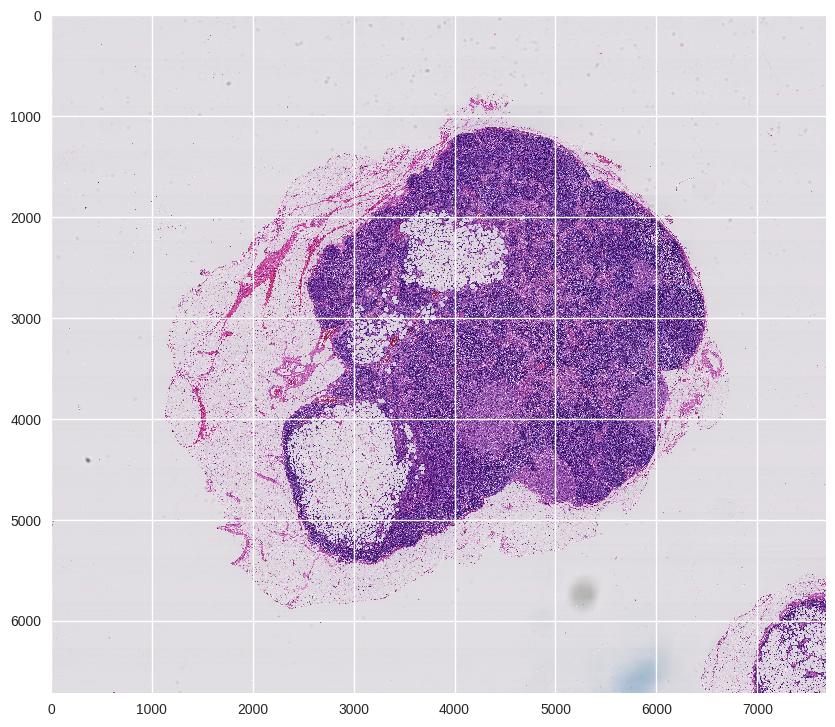

In [179]:
# Example: read the entire slide at level 5

# High zoom levels may not fit into memory.
# That's why we use OpenSlide. You can use the below function
# to extract regions from high zoom levels without having to 
# read the entire image.

# Note: this is just for demo purposes. 

# Use the sliding window approach discussed in class to collect training
# data for your classifier. E.g., slide a window across the slide (for
# starters, use a zoomed out view, so you're not working with giant images).
# Save each window to disk as an image. To find the label for that image, 
# check to see if same region on the mask image contains cancerous cells.

# Important: this is tricky to get right. Carefully debug your pipeline before
# training your model. Start with just a single image, and a relatively 
# low zoom level.

slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=3, 
                         width=slide.level_dimensions[3][0], 
                         height=slide.level_dimensions[3][1])

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)

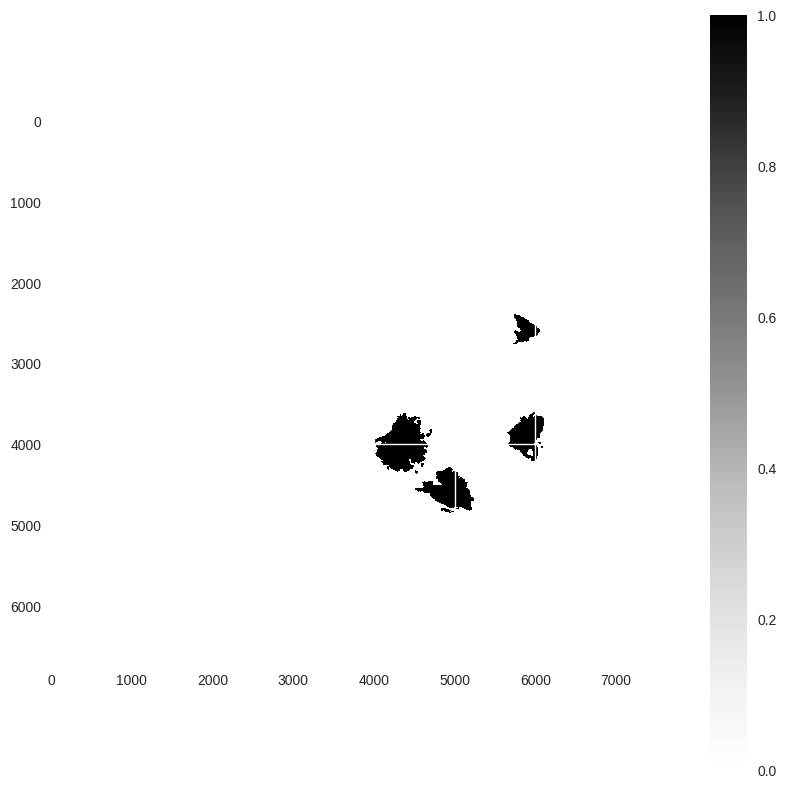

In [180]:
# Example: read the entire mask at the same zoom level
mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=3, 
                        width=slide.level_dimensions[3][0], 
                        height=slide.level_dimensions[3][1])

# Note: the program provided by the dataset authors generates a mask with R,G,B channels.
# The mask info we need is in the first channel only.
# If you skip this step, the mask will be displayed as all black.
mask_image = mask_image[:,:,0]

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(mask_image)
plt.colorbar()

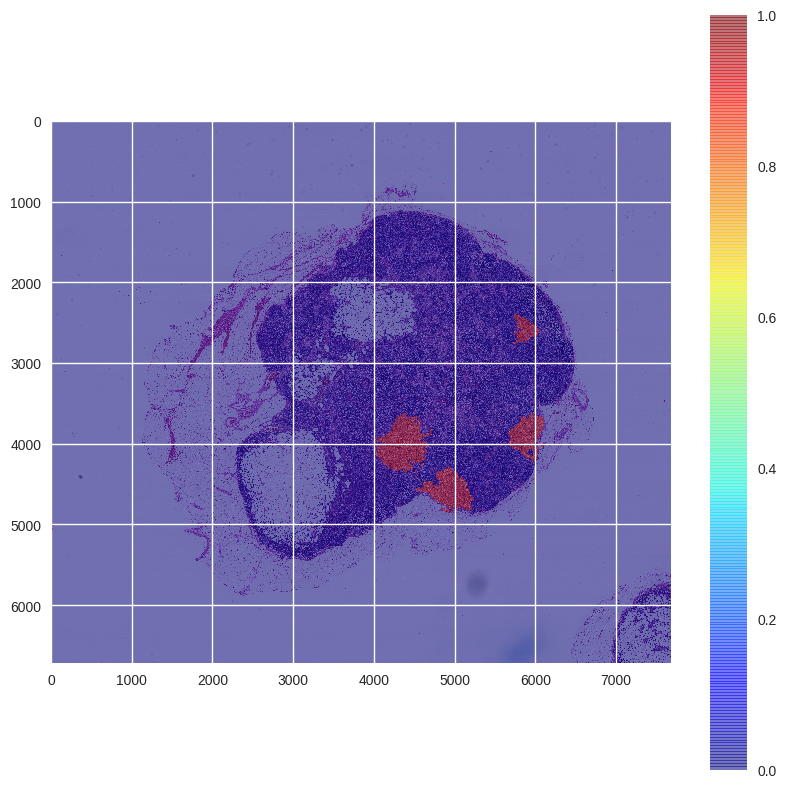

In [181]:
# Overlay them. The idea is that the mask shows the region of the slide that
# contain cancerous cells.

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='jet', alpha=0.5) # Red regions contains cancer.
plt.colorbar()

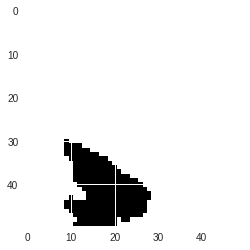

In [182]:
# Example: extract a region from the L7 downsampled image
# Notice we're multiplying the x,y coordinates by the downsample factor.
# This math can be tricky to get right, debug carefully.
# Here, we're "aiming" for the top right blob in the image above.
region = read_slide(tumor_mask, x=350 * 128, y=120 * 128, level=7, width=50, height=50)[:,:,1]
plt.imshow(region)

In [183]:
%%time
#creating samples by sliding through the windows



#w = slide.level_dimensions[7][0]/10
#h = slide.level_dimensions[7][1]/10

#y_lim = slide.level_dimensions[0][1]
#x_lim = slide.level_dimensions[0][0]

#regions = list()
#targets = list()

#x_coord = 0
#y_coord = 0
#j = 0
#c = 1

#while y_coord < y_lim:
#  i = 0
#  x_coord = 0
#  
#  while x_coord < x_lim:
#    region_sample = read_slide(slide, x = x_coord, y = y_coord, level = 7, width = w, height = h)
#    region_tumor = read_slide(tumor_mask, x = x_coord, y = y_coord, level = 7, width = w, height = h)[:,:,1]
#    regions.append(region_sample)
#    targets.append(region_tumor)
    #print("sample %d added, %d x_coord, %d y_coord" % (c, x_coord, y_coord))
#    i += 1
#    c += 1
#    x_coord = 0 + i*w*128
   
    
#  j += 1
#  y_coord = 0 + j*h*128
#print("%d samples added" % (c))

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 12.2 µs


In [184]:
%%time
#Level 7 dimension: 480 x 420
from skimage.transform import resize
import math

window = 120
width_lim = math.ceil(float(slide.level_dimensions[3][0])/float(window))
height_lim = math.ceil(float(slide.level_dimensions[3][1])/float(window))


print(width_lim, height_lim)

X = list()
y = list()

for i in range(int(width_lim)):
  for j in range(int(height_lim)):
    slide_region = read_slide(slide, x= i * window * 8, 
                                     y= j * window * 8, 
                                     level=3, width= window, height=window)

    tumor_region = read_slide(tumor_mask, x= i * window * 8, 
                                     y= j * window * 8, 
                                     level=3, width= window, height=window)[:,:,1]
    X.append(slide_region)
    y.append(int(math.ceil(np.mean(tumor_region))))
    
X = np.array(X)
y = np.array(y)

print(X.shape)
print(y.shape)

(64.0, 56.0)
(3584, 120, 120, 3)
(3584,)
CPU times: user 5.73 s, sys: 114 ms, total: 5.84 s
Wall time: 5.84 s


In [0]:
#from skimage.transform import resize

#def slidingwindow(slide, w, h, window_size):
#  return slide[w:w+window_size, h:h+window_size]


#def generatingdataset(slide, slide2, step_size, window_size):
#  w = 0
#  h = 0
#  dataset = list()
#  target = list()
#  for j in range((slide2.shape[1]-window_size)/step_size):
#    for i in range((slide2.shape[0]-window_size)/step_size):
#      dataset.append(slidingwindow(slide, i*step_size, j*step_size, window_size))
#      target.append(slidingwindow(slide2, j*step_size, j*step_size, window_size))
#      
#  return np.array(dataset), np.array(target)

In [0]:
#%%time
#X, y = generatingdataset(slide_image, mask_image, 4, 50)
#print(X.shape, y.shape)

In [0]:
#y_label = []
#for target in y:
#  if target.sum() > 1:
#    y_label += [1]
#  else:
#    y_label += [0]

In [185]:
from sklearn.model_selection import train_test_split

X_train,X_test, y_train, y_test = train_test_split(X, y, random_state = 0)
print(len(X_train), len(y_train))

(2688, 2688)


In [0]:
#!pip install imblearn

In [0]:
# undersampling
majority_index = np.where(y_train == 0)[0]
m = (y_train == 1).sum()
#print(m)
sample_index = np.random.choice(majority_index, size = m, replace = False)
#print(len(sample_index))

X_sample = np.append(X_train[sample_index],X_train[np.where(y_train == 1)], axis = 0)
y_sample = np.append(y_train[sample_index], y_train[np.where(y_train == 1)])

In [0]:
np.random.seed(0)
sample_index = np.arange(X_sample.shape[0])
np.random.shuffle(sample_index)

X_sample2 = X_sample[sample_index]
y_sample2 = y_sample[sample_index]

In [189]:
from collections import Counter

c = Counter(y_sample2)
print(c)

Counter({0: 78, 1: 78})


Inception Model

freezing conv base

In [273]:
inception = tf.keras.applications.inception_v3.InceptionV3(input_shape = (120, 120, 3), include_top = False,
                                                          weights = 'imagenet')

inception.trainable = False
#inception.summary()

KeyboardInterrupt: ignored

use architecture

In [0]:
inception = tf.keras.applications.inception_v3.InceptionV3(input_shape = (120, 120, 3), include_top = False)


In [0]:
model_inception = tf.keras.Sequential([
    inception,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(2, activation = 'softmax')
])

In [0]:
model_inception.compile(optimizer=tf.train.AdamOptimizer(), 
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=["accuracy"])

In [290]:
model_inception.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 2, 2, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_17  (None, 2048)              0         
_________________________________________________________________
dense_29 (Dense)             (None, 64)                131136    
_________________________________________________________________
dense_30 (Dense)             (None, 2)                 130       
Total params: 21,934,050
Trainable params: 21,899,618
Non-trainable params: 34,432
_________________________________________________________________


In [291]:
model_inception.fit(X_sample2, y_sample2, epochs = 15, batch_size = 32, validation_split = 0.1)

Train on 140 samples, validate on 16 samples
Epoch 1/15
140/140 [==============================] - 80s 568ms/step - loss: 0.5811 - acc: 0.7143 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 2/15
140/140 [==============================] - 1s 9ms/step - loss: 0.2739 - acc: 0.9000 - val_loss: 7.7380 - val_acc: 0.5000
Epoch 3/15
140/140 [==============================] - 1s 8ms/step - loss: 0.1612 - acc: 0.9643 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 4/15
140/140 [==============================] - 1s 8ms/step - loss: 0.1155 - acc: 0.9643 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 5/15
140/140 [==============================] - 1s 8ms/step - loss: 0.1127 - acc: 0.9714 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 6/15
140/140 [==============================] - 1s 8ms/step - loss: 0.0742 - acc: 0.9857 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 7/15
140/140 [==============================] - 1s 8ms/step - loss: 0.0627 - acc: 0.9786 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 8/15
140/140 [========

finetune

In [195]:
inception.trainable = True

i = 0
while inception.layers[i].name.startswith('mixed8') == False:
  inception.layers[i].trainable = False
  i += 1

inception.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 120, 120, 3)  0                                            
__________________________________________________________________________________________________
conv2d_564 (Conv2D)             (None, 59, 59, 32)   864         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_564 (BatchN (None, 59, 59, 32)   96          conv2d_564[0][0]                 
__________________________________________________________________________________________________
activation_564 (Activation)     (None, 59, 59, 32)   0           batch_normalization_564[0][0]    
__________________________________________________________________________________________________
conv2d_565

In [272]:
tf.keras.applications.inception_v3.InceptionV3(input_shape = (120, 120, 3), include_top = False)

In [0]:
model_inception.compile(optimizer=tf.train.AdamOptimizer(), 
              loss=tf.keras.losses.binary_crossentropy,
              metrics=["accuracy"])

In [197]:
model_inception.fit(X_sample2, y_sample2, epochs = 5, batch_size = 32, validation_split = 0.1)

Train on 140 samples, validate on 16 samples
Epoch 1/5
140/140 [==============================] - 28s 203ms/step - loss: 0.4722 - acc: 0.8143 - val_loss: 1.8106 - val_acc: 0.6875
Epoch 2/5
140/140 [==============================] - 0s 3ms/step - loss: 0.0585 - acc: 0.9857 - val_loss: 2.3744 - val_acc: 0.5000
Epoch 3/5
140/140 [==============================] - 0s 3ms/step - loss: 0.0803 - acc: 0.9857 - val_loss: 4.1555 - val_acc: 0.5625
Epoch 4/5
140/140 [==============================] - 0s 3ms/step - loss: 0.0246 - acc: 0.9929 - val_loss: 6.9137 - val_acc: 0.5000
Epoch 5/5
140/140 [==============================] - 0s 3ms/step - loss: 0.0075 - acc: 1.0000 - val_loss: 6.7267 - val_acc: 0.5000


In [298]:
y_pred.argmax(axis = 1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [299]:
from sklearn.metrics import roc_curve,  precision_score, recall_score, f1_score

#y_pred = model_inception.predict(X_test)

y_predict_label = y_pred.argmax(axis = 1)

print('Recall: ', recall_score(y_test, y_predict_label))
print('F1: ', f1_score(y_test, y_predict_label))
print('Precision: ', precision_score(y_test, y_predict_label))

('Recall: ', 0.125)
('F1: ', 0.15384615384615385)
('Precision: ', 0.2)


In [283]:
np.where(y_predict_label == 1)

(array([  0,   1,   3,   4,   5,   6,   9,  10,  11,  12,  15,  16,  17,
         18,  21,  22,  23,  24,  25,  28,  29,  30,  31,  33,  34,  35,
         36,  37,  42,  43,  45,  46,  48,  49,  50,  51,  52,  53,  55,
         56,  57,  58,  59,  60,  61,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,
         83,  84,  85,  86,  87,  89,  90,  92,  93,  94,  96,  98, 100,
        101, 103, 104, 105, 106, 108, 109, 110, 111, 112, 113, 114, 116,
        117, 118, 121, 123, 125, 126, 127, 128, 129, 130, 131, 132, 133,
        134, 135, 136, 137, 138, 141, 142, 143, 144, 145, 146, 147, 148,
        149, 152, 153, 154, 155, 158, 159, 160, 161, 162, 164, 165, 166,
        167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179,
        180, 181, 182, 184, 185, 186, 187, 188, 189, 191, 192, 193, 194,
        196, 197, 198, 199, 201, 203, 204, 205, 207, 208, 209, 210, 211,
        212, 213, 214, 215, 217, 219, 220, 221, 222

In [0]:
inception = 

VGG 16

In [0]:
xception = tf.keras.applications.vgg16.VGG16(input_shape = (120,120,3), include_top = False,
                                         weights = 'imagenet')
xception.trainable = False

In [0]:
model_xception = tf.keras.Sequential([
  xception,
  tf.keras.layers.GlobalAveragePooling2D(),
  #tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation = 'relu'),
 # tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1, activation = 'sigmoid')])

In [262]:
model_xception.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 3, 3, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_15  (None, 512)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 64)                32832     
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 65        
Total params: 14,747,585
Trainable params: 32,897
Non-trainable params: 14,714,688
_________________________________________________________________


In [0]:
model_xception.compile(optimizer=tf.train.AdamOptimizer(), 
              loss=tf.keras.losses.binary_crossentropy,
              metrics=["accuracy"])

In [266]:
model_xception.fit(X_sample2, y_sample2, epochs = 5, batch_size = 32, validation_split = 0.1)

Train on 140 samples, validate on 16 samples
Epoch 1/5
140/140 [==============================] - 1s 4ms/step - loss: 0.0494 - acc: 0.9857 - val_loss: 0.4796 - val_acc: 0.8125
Epoch 2/5
140/140 [==============================] - 1s 4ms/step - loss: 0.0286 - acc: 1.0000 - val_loss: 0.4737 - val_acc: 0.7500
Epoch 3/5
140/140 [==============================] - 1s 4ms/step - loss: 0.0322 - acc: 1.0000 - val_loss: 0.4786 - val_acc: 0.7500
Epoch 4/5
140/140 [==============================] - 1s 4ms/step - loss: 0.0239 - acc: 1.0000 - val_loss: 0.4792 - val_acc: 0.8125
Epoch 5/5
140/140 [==============================] - 1s 4ms/step - loss: 0.0196 - acc: 1.0000 - val_loss: 0.5031 - val_acc: 0.8125


In [267]:
xception.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 120, 120, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 120, 120, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 120, 120, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 60, 60, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 60, 60, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 60, 60, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 30, 30, 128)       0         
__________

In [0]:
xception.trainable = True

for layer in xception.layers:
  if layer.name.startswith('block5') or layer.name.startswith('block4'):
    layer.trainable = True
  else:
    layer.trainable = False

In [269]:
xception.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 120, 120, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 120, 120, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 120, 120, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 60, 60, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 60, 60, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 60, 60, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 30, 30, 128)       0         
__________

In [0]:
model_xception.compile(optimizer=tf.train.AdamOptimizer(), 
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=["accuracy"])

In [271]:
model_xception.fit(X_sample2, y_sample2, epochs = 10, batch_size = 32, validation_split = 0.1)

Train on 140 samples, validate on 16 samples
Epoch 1/10
140/140 [==============================] - 30s 211ms/step - loss: nan - acc: 0.6143 - val_loss: nan - val_acc: 0.5000
Epoch 2/10
140/140 [==============================] - 1s 5ms/step - loss: nan - acc: 0.5000 - val_loss: nan - val_acc: 0.5000
Epoch 3/10
140/140 [==============================] - 1s 5ms/step - loss: nan - acc: 0.5000 - val_loss: nan - val_acc: 0.5000
Epoch 4/10
140/140 [==============================] - 1s 5ms/step - loss: nan - acc: 0.5000 - val_loss: nan - val_acc: 0.5000
Epoch 5/10
140/140 [==============================] - 1s 5ms/step - loss: nan - acc: 0.5000 - val_loss: nan - val_acc: 0.5000
Epoch 6/10
140/140 [==============================] - 1s 5ms/step - loss: nan - acc: 0.5000 - val_loss: nan - val_acc: 0.5000
Epoch 7/10
140/140 [==============================] - 1s 5ms/step - loss: nan - acc: 0.5000 - val_loss: nan - val_acc: 0.5000
Epoch 8/10
140/140 [==============================] - 1s 5ms/step - lo

In [103]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 130       
Total params: 14,747,650
Trainable params: 7,112,386
Non-trainable params: 7,635,264
_________________________________________________________________


In [0]:
vgg16 = 

In [0]:
from sklearn.metrics import roc_curve,  precision_score, recall_score, f1_score

y_predict_label = model.predict(X_sample2).argmax(axis = 1)

print('Recall: ', recall_score(y_sample2, y_predict_label))
print('F1: ', f1_score(y_sample2, y_predict_label))
print('Precision: ', precision_score(y_sample2, y_predict_label))

('Recall: ', 0.913312693498452)
('F1: ', 0.7230392156862746)
('Precision: ', 0.5983772819472617)


In [0]:
print("The test score is: ", model.evaluate(X_test, y_test))

5198/5198 [==============================] - 5s 960us/step
('The test score is: ', [2.317429236468557, 0.23951519818753636])


In [0]:
y_pred = model.predict(X_test)
y_pred

array([[0.99637127, 0.00362876],
       [0.33856112, 0.66143894],
       [0.38861746, 0.6113825 ],
       ...,
       [0.99876946, 0.00123054],
       [0.5046374 , 0.49536255],
       [0.3219059 , 0.678094  ]], dtype=float32)

In [0]:
from sklearn.metrics import roc_curve,  precision_score, recall_score, f1_score

y_predict_label = y_pred.argmax(axis = 1)

print('Recall: ', recall_score(y_test, y_predict_label))
print('F1: ', f1_score(y_test, y_predict_label))
print('Precision: ', precision_score(y_test, y_predict_label))

('Recall: ', 0.6938775510204082)
('F1: ', 0.03325996576179995)
('Precision: ', 0.0170383362565773)


13344403 tissue_pixels pixels (29.6 percent of the image)


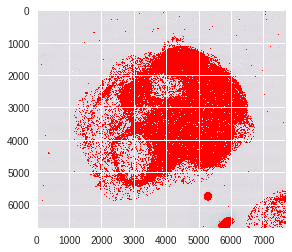

In [0]:
# As mentioned in class, we can improve efficiency by ignoring non-tissue areas 
# of the slide. We'll find these by looking for all gray regions.
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return zip(indices[0], indices[1])

tissue_pixels = find_tissue_pixels(slide_image)
percent_tissue = len(tissue_pixels) / float(slide_image.shape[0] * slide_image.shape[0]) * 100
print ("%d tissue_pixels pixels (%.1f percent of the image)" % (len(tissue_pixels), percent_tissue)) 

def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

tissue_regions = apply_mask(slide_image, tissue_pixels)
plt.imshow(tissue_regions)

In [0]:
from collections import Counter
c = Counter(y_sample2)

In [58]:
print(c)

Counter({0: 323, 1: 323})
